# Flowers Recognition

## Objective:
Buil an automation which can create a classifier capable of determining a flower’s species from a photo.

#### Context:
University X is currently undergoing some research involving understanding the characteristics of
flowers. They already have invested on curating sample images. They require an automation which can
create a classifier capable of determining a flower’s species from a photo.

#### Dataset Source: 
https://www.kaggle.com/datasets/alxmamaev/flowers-recognition

#### Data
- The pictures are divided into five classes: chamomile, tulip, rose, sunflower, dandelion.
- For each class there are about 800 photos. Photos are not high resolution, about 320x240 pixels. 
- Photos are not reduced to a single size, they have different proportions!

##### Acknowledgements:
The data collection is based on scraped data from flickr, google images, and yandex images.

# 1. Loading and Understanding the data

In [1]:
import pandas as pd                                                 # for panel data analysis
pd.set_option('display.max_columns', None)                          # Unfolding hidden features if the cardinality is high      
pd.set_option('display.max_colwidth', None)                         # Unfolding the max feature width for better clrity      
pd.set_option('display.max_rows', None)                             # Unfolding hidden data points if the cardinality is high
pd.set_option('display.float_format', lambda x: '%.3f' % x)         # To suppress scientific notation over exponential values
#-------------------------------------------------------------------------------------------------------------------------------
import numpy as np                                                  # Importing package numpys (For Numerical Python)
#-------------------------------------------------------------------------------------------------------------------------------
import matplotlib.pyplot as plt                                     # Importing pyplot interface using matplotlib
from matplotlib.pylab import rcParams                               # Backend used for rendering and GUI integration                                               
import seaborn as sns                                               # Importin seaborn library for interactive visualization
#set seaborn plotting aesthetics
sns.set(style='whitegrid')
%matplotlib inline  

In [2]:
import tensorflow as tf
import keras

import os
from pathlib import Path
from tensorflow.keras.utils import get_file
import glob

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

### Import the data. 

In [3]:
# in case we have downloaded a zipfile

# Setting an appropriate path for the dataset(zip)
##zipfile = r'D:\Datasets\Flowers Recognition.zip' 
#prefixing the string with r (to produce a raw string)

# Extracting the dataset(zip) to the a working directory
##with ZipFile(zipfile, 'r') as zipped: #reading the zip file
  ##zipped.extractall(r'D:\Datasets') #extracting the contents of the file into a new folder

##os.listdir(r'D:\Datasets\flowers')

In [4]:
# when we are using Kaggle
# dataset_url = '../input/flowers-recognition'

In [5]:
# downloading data from tensorflow library
from tensorflow.keras.utils import get_file


dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = get_file('flower_photos', origin=dataset_url, untar=True)
directory = Path(data_dir)

In [6]:
image_count = len(list(directory.glob('*/*.jpg')))
print('Total number of images in the dataset are:', image_count)

Total number of images in the dataset are: 3670


We already expect the model to overfit. Our dataset  is not big enough

In [7]:
# checking the directory where the images are, to understand its structure
os.listdir(directory)

['roses', 'dandelion', 'sunflowers', 'LICENSE.txt', 'daisy', 'tulips']

In [8]:
img_height = 224
img_width = 224
batch_size = 32
seed = 42

In [9]:
from tensorflow.keras.utils import image_dataset_from_directory as idfd

In [10]:
train_ds = idfd(
    directory,
    shuffle = True,
    label_mode = 'categorical',
    validation_split = 0.4,
    subset = 'training',
    seed=seed,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 3670 files belonging to 5 classes.
Using 2202 files for training.


2022-11-11 13:41:12.423256: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-11 13:41:12.424156: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-11 13:41:12.435519: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-11 13:41:12.436345: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-11 13:41:12.437098: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [11]:
val_ds = idfd(
    directory,
    shuffle = True,
    label_mode = 'categorical',
    validation_split = 0.4,
    subset = 'validation',
    seed=seed,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 3670 files belonging to 5 classes.
Using 1468 files for validation.


In [12]:
class_names = train_ds.class_names
print('List of classes classes:',class_names)

num_classes = len(class_names)
print('Number of neurons in output layer:',num_classes)

List of classes classes: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
Number of neurons in output layer: 5


#### Sample Images

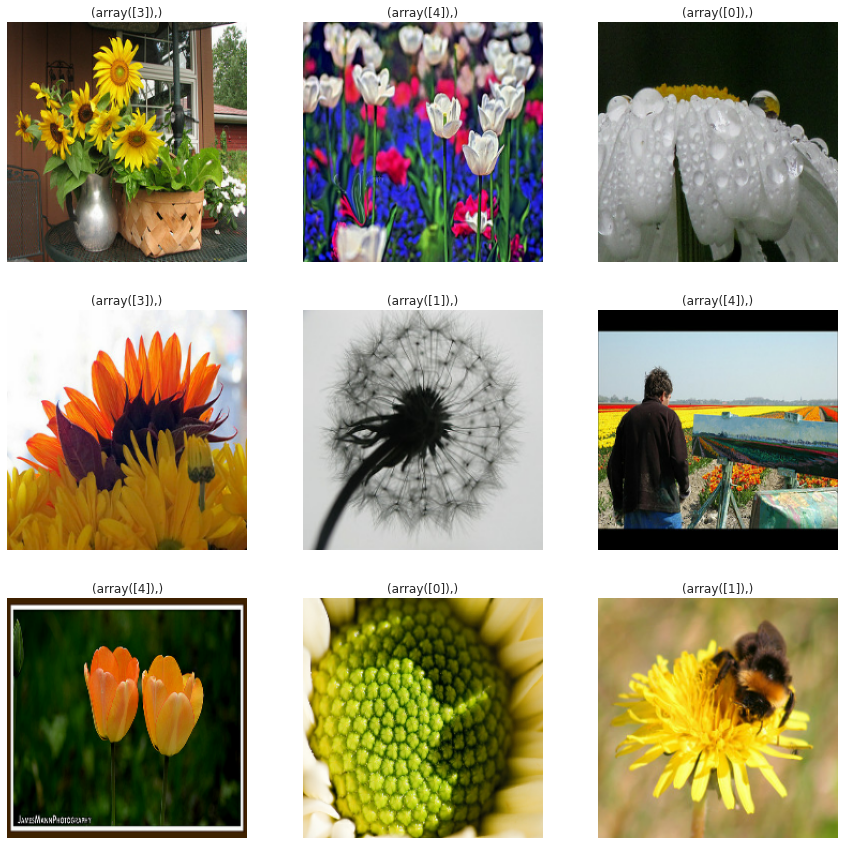

In [80]:
plt.figure(figsize=(15, 15))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        labn = labels[i].numpy().astype('uint8')
        label = np.where(labn == 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(label)
        plt.axis("off")

In [14]:
print('Checking the image and label batch in terms of their size')

for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

Checking the image and label batch in terms of their size
(32, 224, 224, 3)
(32, 5)


In [15]:
# taking a sample batch and noting the number of chanels
num_channels = image_batch[0].ndim
print('Number of channels:', num_channels)

Number of channels: 3


In [16]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 3)
val_ds = val_ds.skip(val_batches // 3)

In [17]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Number of validation batches: 31
Number of test batches: 15


Rescaling layer

In [18]:
rescale = tf.keras.Sequential([
  layers.Rescaling(1./255)
])

Augmentation layer

In [19]:
augment = tf.keras.Sequential(
  [
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),
  ]
)

# MODELLING

In [20]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall

In [21]:
metrics = [
    'accuracy',
    Precision(name='precision'),
    Recall(name='recall')
]

In [22]:
def evolution(model, epochs):
    epochs = range(1,epochs+1)
    
    plt.figure(figsize=(20, 25))
    
    plt.subplot(4, 2, 1)
    loss_train = model.history['loss']
    loss_val = model.history['val_loss']
    plt.plot(epochs, loss_train, 'g', label='Training loss')
    plt.plot(epochs, loss_val, 'b', label='validation loss')
    plt.title('Loss Function Evolution')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    
    plt.subplot(4, 2, 2)
    accuracy_train = model.history['accuracy']
    accuracy_val = model.history['val_accuracy']
    plt.plot(epochs, accuracy_train, 'g', label='Training accuracy')
    plt.plot(epochs, accuracy_val, 'b', label='validation accuracy')
    plt.title('Accuracy Function Evolution')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()


    plt.subplot(4, 2, 3)
    precision_train = model.history['precision']
    precision_val = model.history['val_precision']
    plt.plot(epochs, precision_train, 'g', label='Training precision')
    plt.plot(epochs, precision_val, 'b', label='validation precision')
    plt.title('Precision Function Evolution')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()



    plt.subplot(4, 2, 4)
    recall_train = model.history['recall']
    recall_val = model.history['val_recall']
    plt.plot(epochs, recall_train, 'g', label='Training recall')
    plt.plot(epochs, recall_val, 'b', label='validation recall')
    plt.title('Recall Function Evolution')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
  

    return()

# 1. Basic CNN [model1]

In [23]:
from tensorflow.keras.layers import Rescaling, Flatten, Conv2D, Dense, MaxPooling2D, BatchNormalization, Dropout, Input

In [28]:
cnn_model1 = Sequential(
[
    Input(shape= (img_height, img_width, num_channels)),
    augment,
    rescale,
    Conv2D(16, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(128, activation='relu'),
    layers.Dense(num_classes, activation = 'softmax')
])

In [29]:
cnn_model1.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics= metrics)

print(cnn_model1.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 56, 56, 64)       

In [30]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience = 2, verbose=1,factor=0.3, 
                                            min_lr=0.000001)

In [31]:
model1_history = cnn_model1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks = [learning_rate_reduction],
)

Epoch 1/50
69/69 [==============================] - 8s 97ms/step - loss: 1.4516 - accuracy: 0.3847 - precision: 0.7209 - recall: 0.3262 - val_loss: 1.1791 - val_accuracy: 0.4808 - val_precision: 0.6584 - val_recall: 0.2672
Epoch 2/50
69/69 [==============================] - 7s 97ms/step - loss: 1.1423 - accuracy: 0.5336 - precision: 0.6525 - recall: 0.3129 - val_loss: 1.1807 - val_accuracy: 0.4990 - val_precision: 0.6198 - val_recall: 0.3613
Epoch 3/50
69/69 [==============================] - 7s 103ms/step - loss: 1.0530 - accuracy: 0.5604 - precision: 0.6567 - recall: 0.3978 - val_loss: 1.0039 - val_accuracy: 0.6022 - val_precision: 0.6905 - val_recall: 0.4585
Epoch 4/50
69/69 [==============================] - 7s 97ms/step - loss: 0.9569 - accuracy: 0.6167 - precision: 0.7074 - recall: 0.4732 - val_loss: 0.9389 - val_accuracy: 0.6215 - val_precision: 0.7101 - val_recall: 0.5182
Epoch 5/50
69/69 [==============================] - 7s 95ms/step - loss: 0.9170 - accuracy: 0.6340 - precis

()

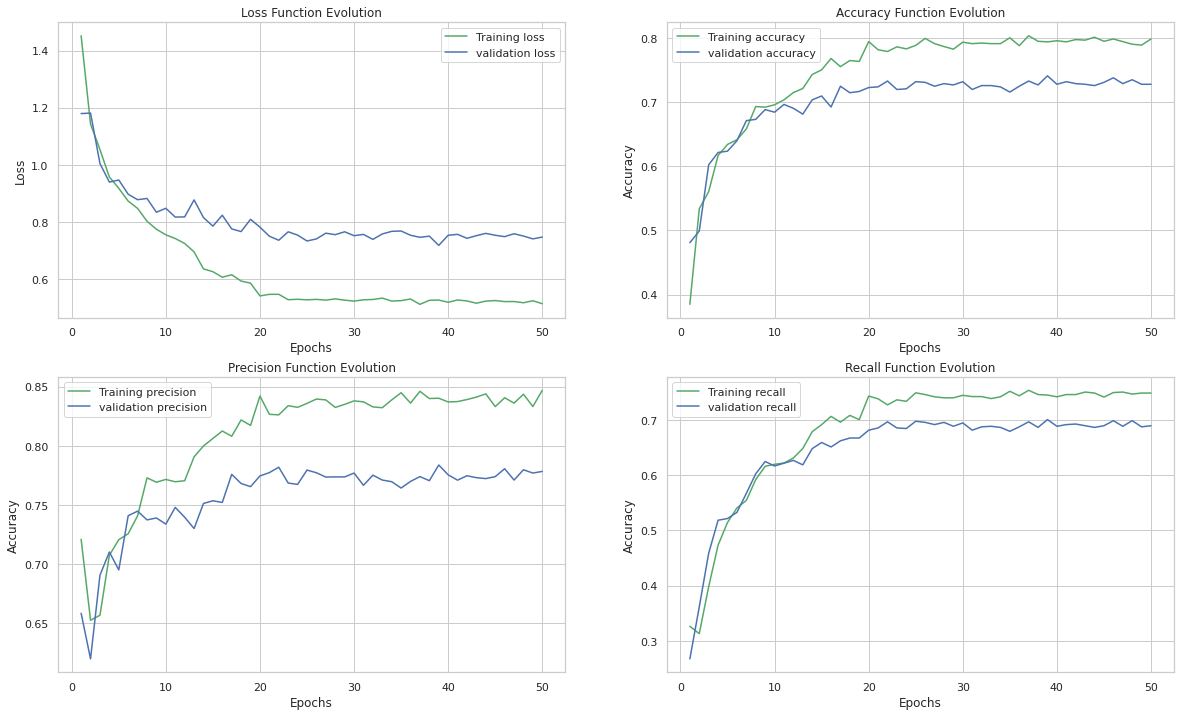

In [32]:
evolution(model1_history,50)

In [33]:
cnn_model1.save('cnn_model1.h5')
cnn_model1.save_weights('cnn_model1_weights.h5')

We need to add a few layers and make the model more complex. But for that we can import the weights of pretrained models,

# 2. Transfer Learning with MobileNet V2 [model2]

In [34]:
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2

In [35]:
base_model = MobileNetV2(input_shape=(img_height, img_width, num_channels),
                                               include_top=False,
                                               weights='imagenet')

In [36]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1280)


In [37]:
base_model.trainable = False

In [38]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [39]:
prediction_layer = tf.keras.layers.Dense(num_classes, 'softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 5)


In [41]:
inputs = tf.keras.Input(shape=(img_height, img_width, num_channels))
x = augment(inputs)
x = rescale(x)
x = base_model(x, training=False)
x = global_average_layer(x)
outputs = prediction_layer(x)
model2_mobileNet = Model(inputs, outputs)

In [42]:
model2_mobileNet.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics= metrics)

In [43]:
model2_history = model2_mobileNet.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks = [learning_rate_reduction],
)

Epoch 1/30
69/69 [==============================] - 13s 133ms/step - loss: 0.8624 - accuracy: 0.6771 - precision: 0.7963 - recall: 0.5771 - val_loss: 0.6303 - val_accuracy: 0.7702 - val_precision: 0.8471 - val_recall: 0.6842
Epoch 2/30
69/69 [==============================] - 8s 108ms/step - loss: 0.5035 - accuracy: 0.8229 - precision: 0.8711 - recall: 0.7734 - val_loss: 0.5123 - val_accuracy: 0.8178 - val_precision: 0.8614 - val_recall: 0.7611
Epoch 3/30
69/69 [==============================] - 8s 111ms/step - loss: 0.4353 - accuracy: 0.8483 - precision: 0.8908 - recall: 0.8079 - val_loss: 0.5005 - val_accuracy: 0.8077 - val_precision: 0.8581 - val_recall: 0.7773
Epoch 4/30
69/69 [==============================] - 8s 114ms/step - loss: 0.3888 - accuracy: 0.8665 - precision: 0.8949 - recall: 0.8315 - val_loss: 0.4979 - val_accuracy: 0.8178 - val_precision: 0.8603 - val_recall: 0.7854

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 5/30
69/69 [====

()

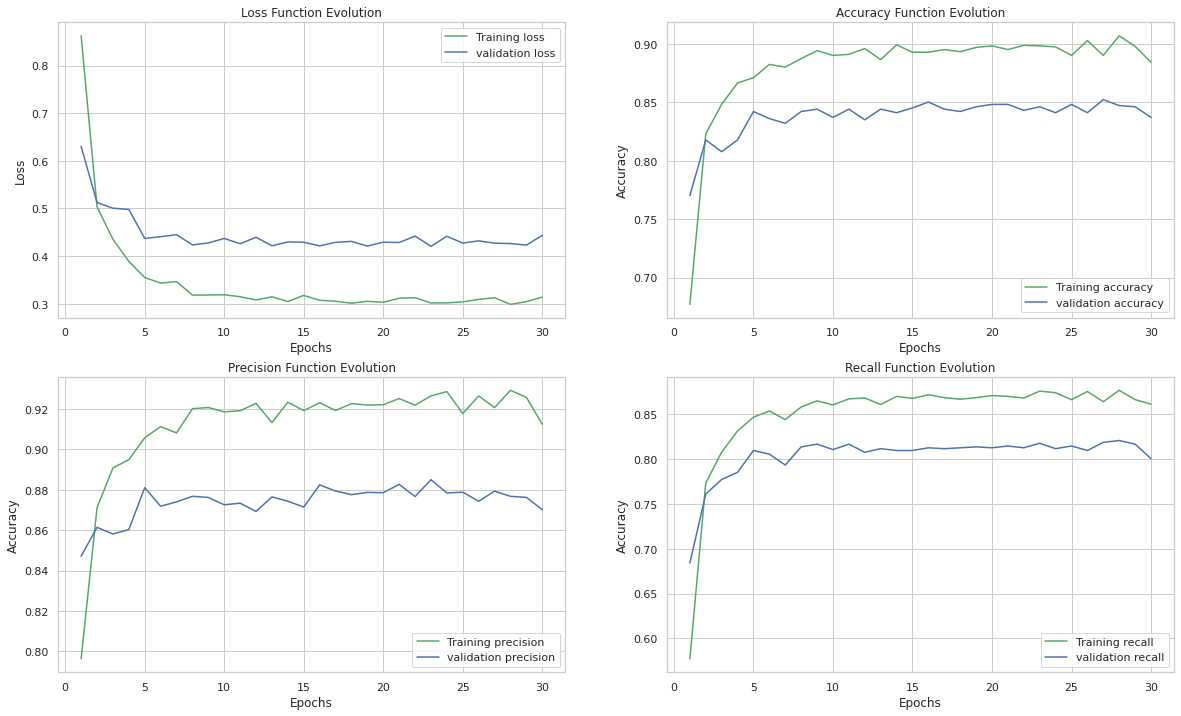

In [46]:
evolution(model2_history,30)

In [47]:
model2_mobileNet.save('model2_mobileNet.h5')
model2_mobileNet.save_weights('model2_mobileNet_weights.h5')

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


# 3. VGG16 [Model3]

Feature Batch shape: (32, 7, 7, 512)
Feature Batch average shape: (32, 512)
Prediction Batch shape: (32, 5)
Epoch 1/41
69/69 [==============================] - 36s 414ms/step - loss: 1.6285 - accuracy: 0.3056 - precision: 0.8489 - recall: 0.2536 - val_loss: 1.4170 - val_accuracy: 0.5253 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/41
69/69 [==============================] - 16s 221ms/step - loss: 1.3752 - accuracy: 0.4614 - precision: 0.8087 - recall: 0.0422 - val_loss: 1.2524 - val_accuracy: 0.6255 - val_precision: 1.0000 - val_recall: 0.0344
Epoch 3/41
69/69 [==============================] - 16s 220ms/step - loss: 1.2283 - accuracy: 0.5654 - precision: 0.8867 - recall: 0.1244 - val_loss: 1.1440 - val_accuracy: 0.6518 - val_precision: 0.9714 - val_recall: 0.1377
Epoch 4/41
69/69 [==============================] - 16s 226ms/step - loss: 1.1439 - accuracy: 0.5949 - precision: 0.8821 - recall: 0.1971 - val_loss: 1.0667 - val_accuracy: 0.6751 - val_precision: 0.9488 - val

()

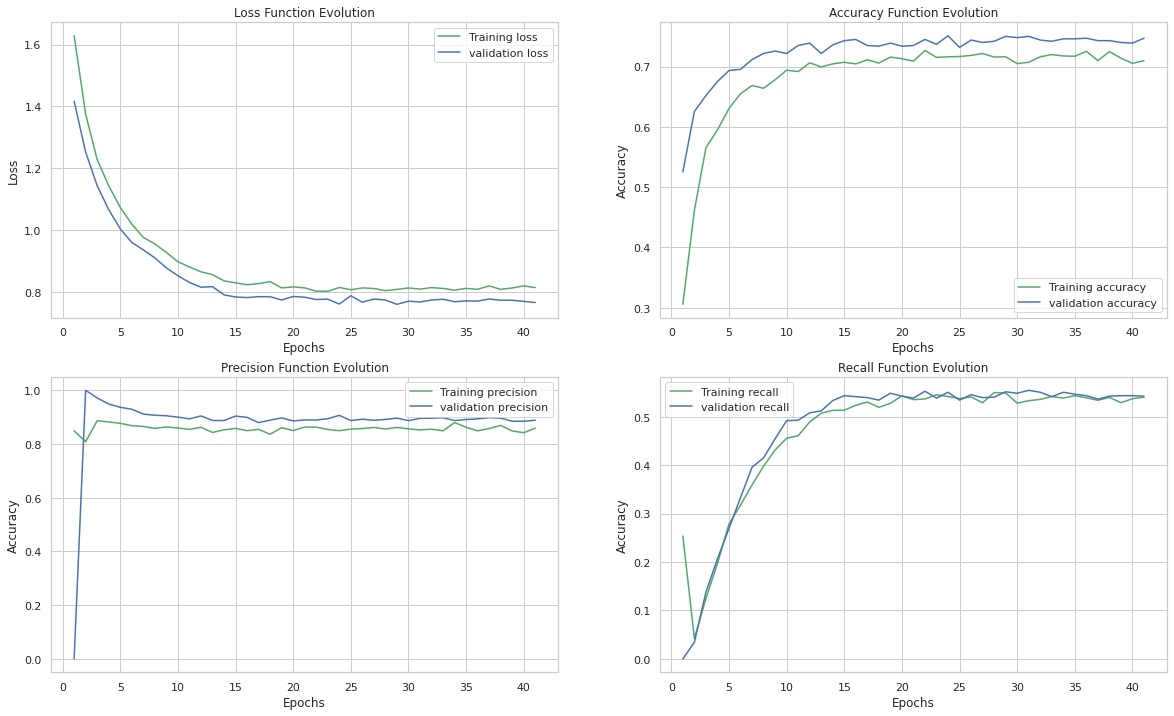

In [48]:
from tensorflow.keras.applications import VGG16

base_modelvgg16 = VGG16(input_shape=(img_height, img_width, num_channels),
                                               include_top=False,
                                               weights='imagenet')

image_batch, labels_batch = next(iter(train_ds))
feature_batch = base_modelvgg16(image_batch)
print('Feature Batch shape:', feature_batch.shape)

base_modelvgg16.trainable = False

global_average_layer = GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print('Feature Batch average shape:', feature_batch_average.shape)

prediction_layer = Dense(num_classes, 'softmax')
prediction_batch = prediction_layer(feature_batch_average)
print('Prediction Batch shape:', prediction_batch.shape)

inputs = Input(shape=(img_height, img_width, num_channels))
x = augment(inputs)
x = rescale(x)
x = base_modelvgg16(x, training=False)
x = global_average_layer(x)
x = Dropout(0.3)(x)

outputs = prediction_layer(x)

model3_VGG16 = Model(inputs, outputs)

model3_VGG16.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics= metrics)

model3_history = model3_VGG16.fit(
    train_ds,
    validation_data=val_ds,
    epochs=41,
    callbacks = [learning_rate_reduction],
)

evolution(model3_history,41)

In [49]:
model3_VGG16.save('model3_VGG16.h5')
model3_VGG16.save_weights('model3_VGG16_weights.h5')

# 4. Resnet [Model4]

94683136/94668760 [==============================] - 0s 0us/step
Feature Batch shape: (32, 7, 7, 2048)
Feature Batch average shape: (32, 2048)
Prediction Batch shape: (32, 5)
Epoch 1/20
69/69 [==============================] - 19s 207ms/step - loss: 0.9328 - accuracy: 0.6526 - precision: 0.7873 - recall: 0.5536 - val_loss: 0.5279 - val_accuracy: 0.8168 - val_precision: 0.8728 - val_recall: 0.7500
Epoch 2/20
69/69 [==============================] - 11s 159ms/step - loss: 0.5797 - accuracy: 0.7843 - precision: 0.8361 - recall: 0.7252 - val_loss: 0.4555 - val_accuracy: 0.8462 - val_precision: 0.8919 - val_recall: 0.8016
Epoch 3/20
69/69 [==============================] - 11s 161ms/step - loss: 0.5013 - accuracy: 0.8147 - precision: 0.8598 - recall: 0.7716 - val_loss: 0.4462 - val_accuracy: 0.8462 - val_precision: 0.8895 - val_recall: 0.8067
Epoch 4/20
69/69 [==============================] - 12s 165ms/step - loss: 0.4542 - accuracy: 0.8351 - precision: 0.8742 - recall: 0.7925 - val_loss: 

()

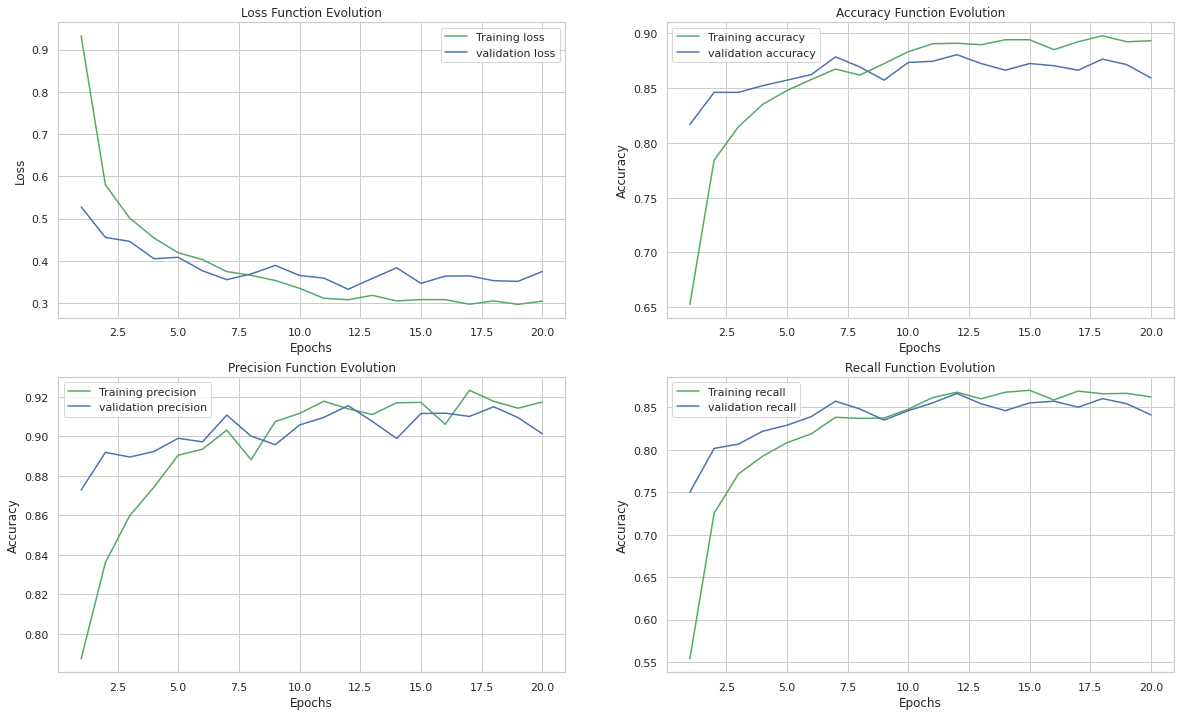

In [50]:
from tensorflow.keras.applications import ResNet50V2

base_modelresnet50 = ResNet50V2(input_shape = (img_height,img_width,num_channels),
                   weights='imagenet',
                   include_top=False)

image_batch, labels_batch = next(iter(train_ds))
feature_batch = base_modelresnet50(image_batch)
print('Feature Batch shape:', feature_batch.shape)

base_modelresnet50.trainable = False

global_average_layer = GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print('Feature Batch average shape:', feature_batch_average.shape)

prediction_layer = Dense(num_classes, 'softmax')
prediction_batch = prediction_layer(feature_batch_average)
print('Prediction Batch shape:', prediction_batch.shape)

inputs = Input(shape=(img_height, img_width, num_channels))
x = augment(inputs)
x = rescale(x)
x = base_modelresnet50(x, training=False)
x = global_average_layer(x)
x = Dropout(0.3)(x)

outputs = prediction_layer(x)

model4_resnet = Model(inputs, outputs)

model4_resnet.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics= metrics)

model4_history = model4_resnet.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks = [learning_rate_reduction],
)

evolution(model4_history,20)

model4_resnet is already trained for 20 epochs. We will train it for 50 more epochs, making total epochs to be 70.

In [58]:
model4_history = model4_resnet.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks = [learning_rate_reduction],
)

Epoch 1/50
69/69 [==============================] - 11s 159ms/step - loss: 0.3155 - accuracy: 0.8896 - precision: 0.9152 - recall: 0.8579 - val_loss: 0.3655 - val_accuracy: 0.8735 - val_precision: 0.9086 - val_recall: 0.8553
Epoch 2/50
69/69 [==============================] - 12s 170ms/step - loss: 0.3145 - accuracy: 0.8833 - precision: 0.9096 - recall: 0.8592 - val_loss: 0.3494 - val_accuracy: 0.8725 - val_precision: 0.9120 - val_recall: 0.8492
Epoch 3/50
69/69 [==============================] - 11s 155ms/step - loss: 0.3059 - accuracy: 0.8865 - precision: 0.9117 - recall: 0.8579 - val_loss: 0.3635 - val_accuracy: 0.8674 - val_precision: 0.9050 - val_recall: 0.8482
Epoch 4/50
69/69 [==============================] - 11s 158ms/step - loss: 0.3042 - accuracy: 0.8933 - precision: 0.9182 - recall: 0.8660 - val_loss: 0.3538 - val_accuracy: 0.8715 - val_precision: 0.9082 - val_recall: 0.8512
Epoch 5/50
69/69 [==============================] - 11s 155ms/step - loss: 0.3059 - accuracy: 0.8869

Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7f65292844d0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/tensorflow/python/data/ops/iterator_ops.py", line 546, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1264, in delete_iterator
    _ctx, "DeleteIterator", name, handle, deleter)
KeyboardInterrupt: 


Epoch 22/50
69/69 [==============================] - 12s 163ms/step - loss: 0.2998 - accuracy: 0.8915 - precision: 0.9140 - recall: 0.8683 - val_loss: 0.3638 - val_accuracy: 0.8664 - val_precision: 0.9047 - val_recall: 0.8451


Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7f65292844d0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/tensorflow/python/data/ops/iterator_ops.py", line 546, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1264, in delete_iterator
    _ctx, "DeleteIterator", name, handle, deleter)
KeyboardInterrupt: 


Epoch 23/50
69/69 [==============================] - 11s 159ms/step - loss: 0.3146 - accuracy: 0.8892 - precision: 0.9131 - recall: 0.8642 - val_loss: 0.3512 - val_accuracy: 0.8674 - val_precision: 0.9080 - val_recall: 0.8492
Epoch 24/50
69/69 [==============================] - 11s 157ms/step - loss: 0.3079 - accuracy: 0.8865 - precision: 0.9202 - recall: 0.8588 - val_loss: 0.3423 - val_accuracy: 0.8735 - val_precision: 0.9104 - val_recall: 0.8532
Epoch 25/50
69/69 [==============================] - 12s 163ms/step - loss: 0.3192 - accuracy: 0.8856 - precision: 0.9069 - recall: 0.8583 - val_loss: 0.3529 - val_accuracy: 0.8725 - val_precision: 0.9062 - val_recall: 0.8512
Epoch 26/50
69/69 [==============================] - 11s 158ms/step - loss: 0.2946 - accuracy: 0.8924 - precision: 0.9099 - recall: 0.8665 - val_loss: 0.3494 - val_accuracy: 0.8725 - val_precision: 0.9093 - val_recall: 0.8522
Epoch 27/50
69/69 [==============================] - 12s 163ms/step - loss: 0.3236 - accuracy: 0

()

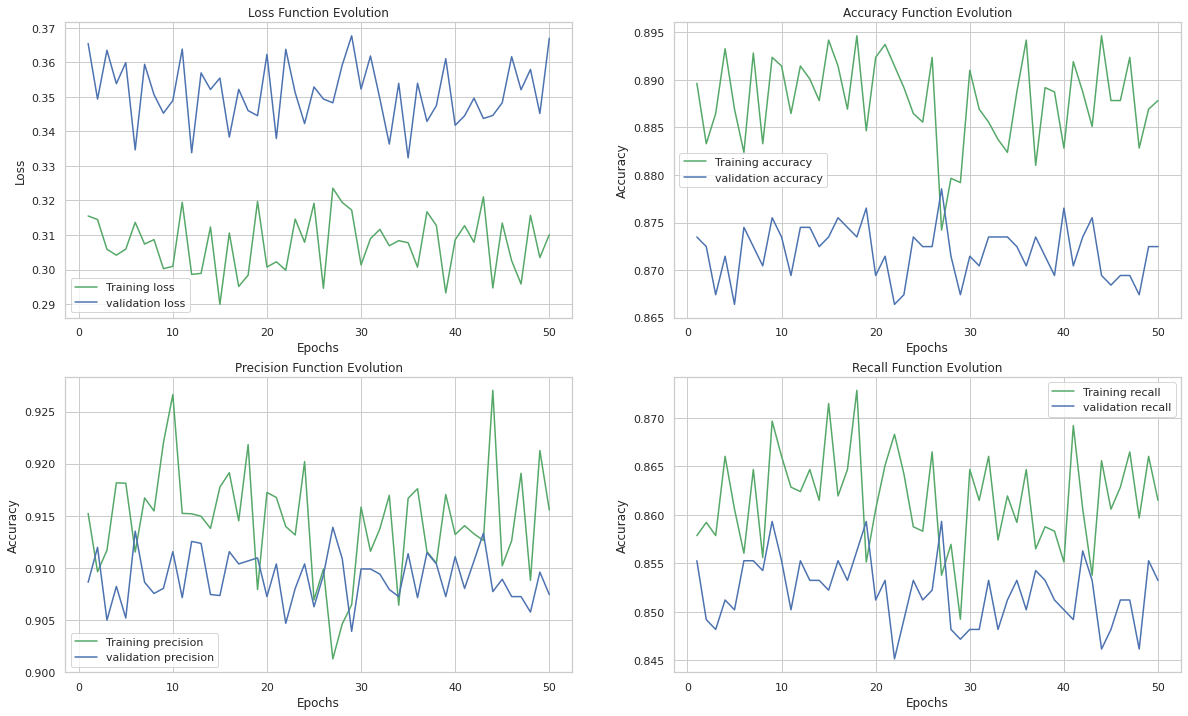

In [59]:
evolution(model4_history,50)

In [60]:
model4_resnet.save('model4_resnet.h5')
model4_resnet.save_weights('model4_resnet_weights.h5')

# Xception [Model 5]

83697664/83683744 [==============================] - 0s 0us/step
Feature Batch shape: (32, 7, 7, 2048)
Feature Batch average shape: (32, 2048)
Prediction Batch shape: (32, 5)
Epoch 1/50
69/69 [==============================] - 24s 281ms/step - loss: 0.9317 - accuracy: 0.6580 - precision: 0.8812 - recall: 0.5602 - val_loss: 0.5769 - val_accuracy: 0.7986 - val_precision: 0.9164 - val_recall: 0.6883
Epoch 2/50
69/69 [==============================] - 17s 232ms/step - loss: 0.5848 - accuracy: 0.7920 - precision: 0.8988 - recall: 0.6857 - val_loss: 0.4832 - val_accuracy: 0.8310 - val_precision: 0.8967 - val_recall: 0.7642
Epoch 3/50
69/69 [==============================] - 16s 227ms/step - loss: 0.4984 - accuracy: 0.8224 - precision: 0.8949 - recall: 0.7421 - val_loss: 0.4432 - val_accuracy: 0.8421 - val_precision: 0.8970 - val_recall: 0.7844
Epoch 4/50
69/69 [==============================] - 16s 223ms/step - loss: 0.4525 - accuracy: 0.8401 - precision: 0.9086 - recall: 0.7761 - val_loss: 

ValueError: x and y must have same first dimension, but have shapes (20,) and (50,)

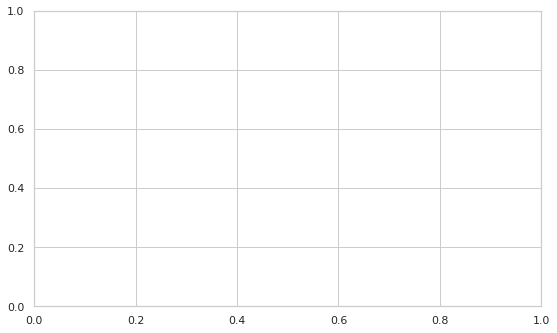

In [56]:
from tensorflow.keras.applications import Xception

base_modelXception = Xception(input_shape = (img_height,img_width,num_channels),
                   weights='imagenet',
                   include_top=False)

image_batch, labels_batch = next(iter(train_ds))
feature_batch = base_modelXception(image_batch)
print('Feature Batch shape:', feature_batch.shape)

base_modelXception.trainable = False

global_average_layer = GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print('Feature Batch average shape:', feature_batch_average.shape)

prediction_layer = Dense(num_classes, 'softmax')
prediction_batch = prediction_layer(feature_batch_average)
print('Prediction Batch shape:', prediction_batch.shape)

inputs = Input(shape=(img_height, img_width, num_channels))
x = augment(inputs)
x = rescale(x)
x = base_modelXception(x, training=False)
x = global_average_layer(x)
x = Dropout(0.3)(x)

outputs = prediction_layer(x)

model5_Xception = Model(inputs, outputs)

model5_Xception.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics= metrics)

model5_history = model5_Xception.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks = [learning_rate_reduction],
)

()

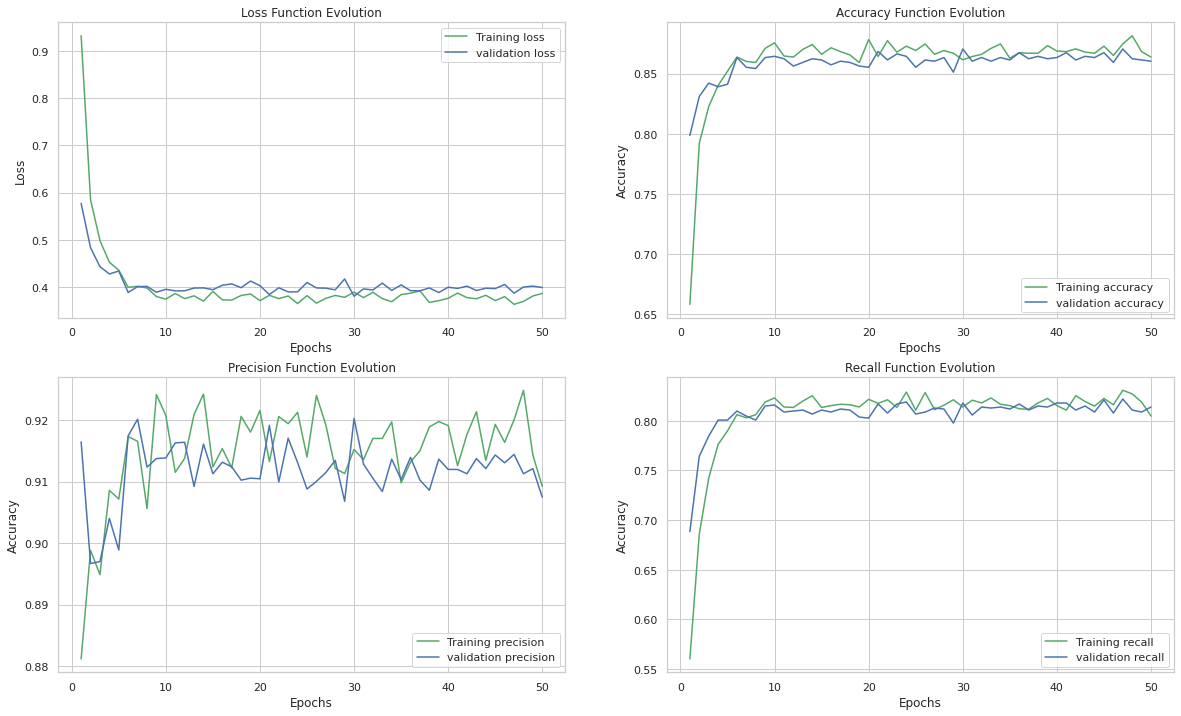

In [57]:
evolution(model5_history,50)

## From the results we can conclude that RESNET outperformed all the other models by giving us a balanced results for training and testing above ~89%. So, we can use RESNET for doing further predictions.

# Loading the saved ResNet model and making the predictions.

In [62]:
from tensorflow.keras.models import load_model

In [63]:
model_resnet = load_model('model4_resnet.h5')

In [94]:
for images, labels in test_ds.take(1):
  for i in range(9):
    img_array = images[i].numpy().astype("uint8")
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    
    predictions = model_resnet.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    
    print('Actual class:', class_names[np.argmax(labels[i])], '|| Predicted class: {}; with a {:.2f} percent confidence.'
          .format(class_names[np.argmax(score)], 100 * np.max(score)),'\n')

Actual class: dandelion || Predicted class: dandelion; with a 34.45 percent confidence. 

Actual class: sunflowers || Predicted class: sunflowers; with a 40.34 percent confidence. 

Actual class: daisy || Predicted class: daisy; with a 40.45 percent confidence. 

Actual class: tulips || Predicted class: tulips; with a 40.44 percent confidence. 

Actual class: daisy || Predicted class: daisy; with a 40.39 percent confidence. 

Actual class: daisy || Predicted class: daisy; with a 40.44 percent confidence. 

Actual class: dandelion || Predicted class: dandelion; with a 40.43 percent confidence. 

Actual class: roses || Predicted class: tulips; with a 27.05 percent confidence. 

Actual class: tulips || Predicted class: tulips; with a 40.14 percent confidence. 

